### Deferred Acceptance Algorithm - Many to Many

#### Introduction

In mathematics, economics, and computer science, the Gale–Shapley algorithm (also known as the deferred acceptance algorithm or propose-and-reject algorithm) is an algorithm for finding a solution to the stable matching problem, named for David Gale and Lloyd Shapley. It takes polynomial time, and the time is linear in the size of the input to the algorithm. It is a truthful mechanism from the point of view of the proposing participants, for whom the solution will always be optimal.

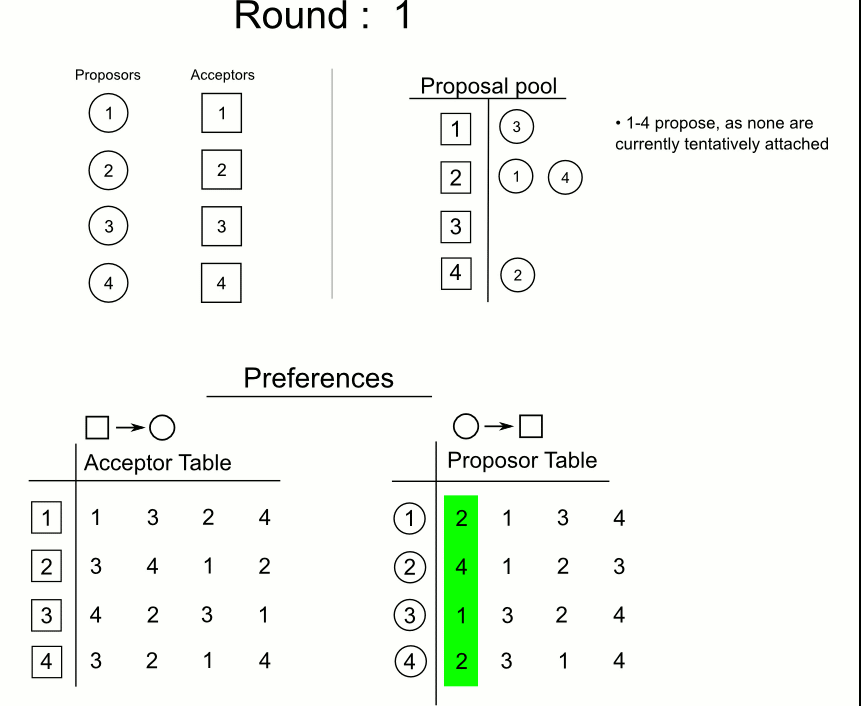

In 1962, David Gale and Lloyd Shapley proved that, for any equal number of participants of each type, it is always possible to find a matching in which all pairs are stable.


The Gale–Shapley algorithm involves a number of "rounds" (or "iterations"). In terms of job applicants and employers, it can be expressed as follows:

In each round, any subset of the employers with open job positions makes a job offer to the applicant they prefer, among the ones they have not yet already made an offer to.
Each applicant who has received an offer evaluates it against their current position (if they have one). If the applicant is not yet employed, or if they receive an offer from an employer they like better than their current employer, they accept the new offer and become matched to the new employer (possibly leaving a previous employer with an open position). Otherwise, they reject the new offer.
This process is repeated until everyone is employed.

The algorithm guarantees that: 

**Everyone gets matched**

At the end, there cannot be an applicant and employer both unmatched. An employer left unmatched at the end of the process must have made an offer to all applicants. But an applicant who receives an offer remains employed for the rest of the process, so there can be no unemployed applicants. Since the numbers of applicants and job openings is equal, there can also be no open positions remaining.

**The matches are stable**

If an applicant X and an employer Y could form an unstable pair, Y would have made an offer to X prior to the offer made by Y to their actual match. But X would have accepted this offer and kept it over the offer they ended up with. Therefore, no such pair is possible.


### The proposed algorithm 
We took the theroy of Gale–Shapley and applied to a specific case: the many-to-many association problem. Strating from a simpler case of One-to-One problem, we developed a Many-to-Many solution, by considering each class having a certain capacity limit. Below you can see the different setting of the two problems.

#### Simple case: one to one algorithm

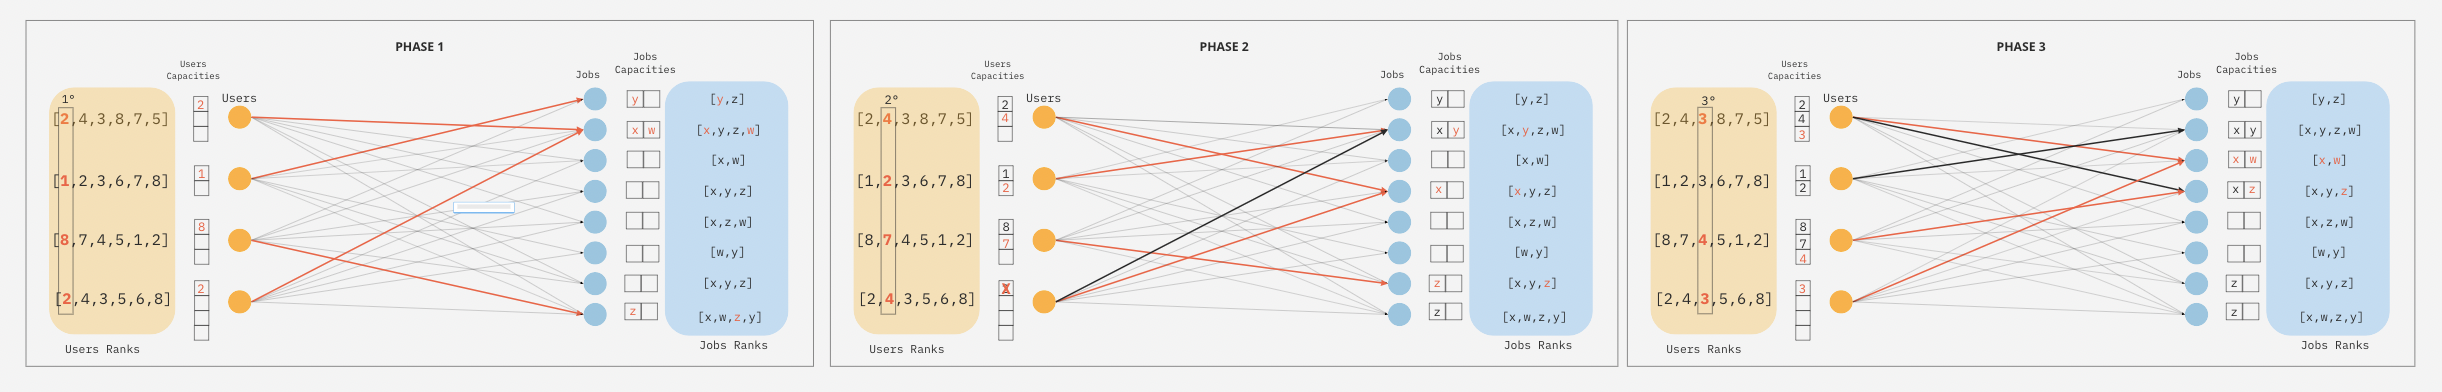

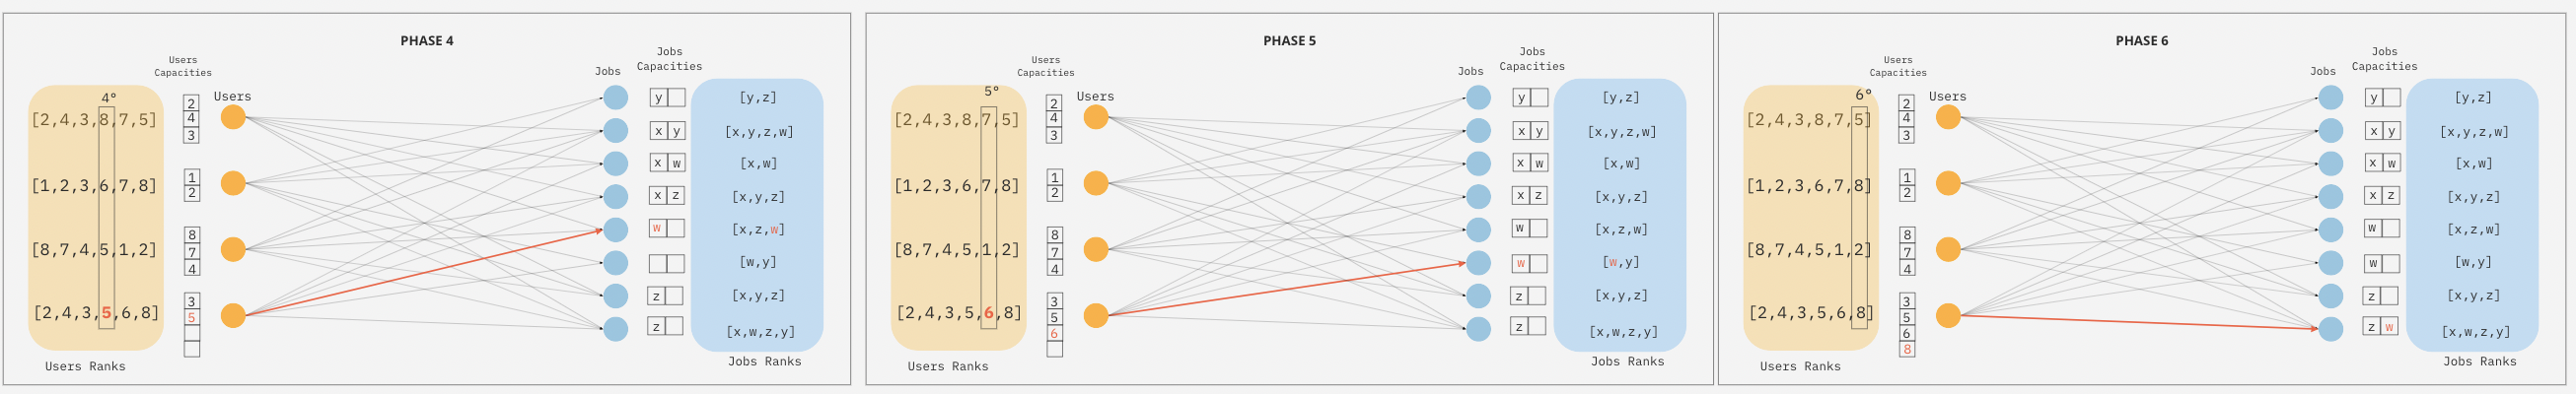

#### Adjusted: many to many algorithm
The main difference from the previous problem is that now Jobs and Users have both a capacity limit; in the example we can imagine that every candidate can have simoultaneously more than 1 job, but of course there is a limit to how many simoultaneous jobs one can have based on their availability. In the same way, every job can be choosen by multiple people dividing the work among themselves, but of course there is a maximum amount to respect. 


###### Phase 1:

we choose an arbitrary starting point (let's start by looking at the users and specifically following the order given): 
User x: 
- User x likes Job 2 
- Check: Job 2 has a free spot (no capacity reach)
- Check: Job 2 likes User x back
- User x and Job 2 matches
- Update: the first spot of User x and Job 2 are filled reciprocally

User y: 
- User y likes Job 1 
- Check: Job 1 has a free spot (no capacity reach)
- Check: Job 1 likes User x back
- User y and Job 1 matches
- Update: the first spots of User y and Job 1 are filled reciprocally

User z: 
- User z likes Job 8 
- Check: Job 8 has a free spot (no capacity reach)
- Check: Job 8 likes User z back
- User z and Job 8 matches
- Update: the first spots of User z and Job 8 are filled reciprocally

User w: 
- User w likes Job 2 
- Check: Job 2 has a free spot (no capacity reach)
- Check: Job 2 likes User w back
- User w and Job 2 matches
- Update: the spot of User w if filled with Job 2 and the second spot of Job 2 is filled with User w


###### Phase 2:
User x: 
- User x likes Job 4 as second preference
- Check: Job 4 has a free spot (no capacity reach)
- Check: Job 4 likes User x back
- User x and Job 4 matches
- Update: the second spot of User x and Job 4 are filled reciprocally

User y: 
- User y likes Job 2
- Check: Job 2 has reach capacity: if Job 2 prefers User y to the User in the last spot (User w) then we substitute
- Check: Job 2 likes User y back and it likes User y more than User w (second preference)
- User y and Job 2 matches
- Update: the second spot of User y is filled with Job 2 while the last spot of Job 2 is substituted with User y, leavng User w, deleting Job 2 from User w's list of recommendations.

User z: 
- User z likes Job 7 
- Check: Job 7 has a free spot (no capacity reach)
- Check: Job 7 likes User z back
- User z and Job 7 matches
- Update: the second spot of User z and the first one of Job 7 are filled reciprocally

User w: 
- User w likes Job 4
- Check: Job 4 has a free spot (no capacity reach)
- Check: Job 4 doesn't likes User w back
- User w and Job 4 don't match, User w is left with no assignment for this phase

###### Phase 3:
User x: 
- User x likes Job 3 as third preference
- Check: Job 3 has a free spot (no capacity reach)
- Check: Job 3 likes User x back
- User x and Job 3 matches
- Update: the third spot of User x and the first one of Job 3 are filled reciprocally

User y: 
- User y has reached capacity. 

User z: 
- User z likes Job 4 
- Check: Job 4 has a free spot (no capacity reach)
- Check: Job 4 likes User z back
- User z and Job 4 matches
- Update: the second spot of User z and of Job 4 are filled reciprocally

User w: 
- User w likes Job 3
- Check: Job 3 has a free spot (no capacity reach)
- Check: Job 3 likes User w back
- Update: the first spot of User w and the second one of Job 3 are filled reciprocally



This logic is applied in phase 4, 5, 6 and at the end we can see that everyone got matched (even though not for every job capacity was reached) and the matching is stable 


#### Imput:
----------------
- `list of users (users = list(User))` each one with its own list of preferred jobs (prefs = list(Job))
- `list of jobs (jobs = list(Job))` each one with its own list of preferred users (prefs = list(User))
- `users_capacities = (dict{user:M})` M variabile 
- `jobs_capacities = job's capacity (dict{job:N})` N variabile 
- `free_subusers` = list of the free_subusers which haven't been matched yet or have been rejected or switched
    (initialized to all sub_users)
- `match = dict{job:[users]}` (empty)

#### Additional imputs to define during the algorithm: 
----------------
- `submatch = dict{subuser: subjob}`, resetting every round and every round it is rebuilt
- `counter = dict{user : count_match }`, counting every time a user is being matched to different jobs, it resets every round

#### PseudoCode: 
-----------------

    while ∃ free_subusers:

        subuser = first subuser from the free_subusers list 
        user = parent of subuser
        favourite = favourite job from user preferences
        
        if user is in favourite's preferences:
           add the current match (job -> user) to the temporary match list of the favurite job 
           temp_match <- ordered_list(job_prefs) ∩ list(temp_match) (ordered based on job_pref) 
           temp_match <- temp_match[:N] where N is the capacity of the job favourite
           
           if the user is no more in temp_match: 
               reappend the subuser to the free_subusers (no match happened)
            
            match[favourite] = temp_match
            initialize submatch
            initialize the counter to 0 for each key_user
            
            for each job_key in the updated match dictionary: 
                for i (sub_job index) and user_value in match[job_key]:
                    j = counter of how many times the user appears in a match (sub_user index)
                    update the submatch dictionary where: {job_key_i : user_value_j}
                    
            
            if there is any sub_users left out from the previous submatch: 
                add the switched (loser) subuser to the free_subusers list
            
            save the current submatch for the next round confrontation 
           
        else if the user is not in its favourite job's preferences:
            add again the initial subuser at the end of the list of free_subusers

        remove the favourite job from user's preferences
        
        if there are no preferences left to be proposed to:
            get all the subusers of the current user and remove them from the free_subusers list 


In [142]:
import pandas as pd
import numpy as np
from typing import Dict, List
from collections import Counter
import collections
import csv
import itertools
import os.path
import random
from collections import defaultdict

np.set_printoptions(suppress=True)

In [143]:
#from matching import BasePlayer
import matching
from matching import Player

In [144]:
class Player:
    """An abstract base class to represent a player within a matching game. 
    Both players and subplayers are Player objects: 
        - a player has capacity > 1 and has a list of subplayers 
            es. Player x {name="x", capacity=3, temp_match = [], subplayers = [x_0, x_1, x_2]}
        - a subplayer has capacity = 1 and has a parent player which it belongs to
             es. Player x_2 {name="x_2", capacity=1, temp_match = [], subplayers = None, parent = Player x}
             
    Parameters
    ----------
    name : object
        An identifier. This should be unique and descriptive.
    capacity : int
       The capacity of the player.
       
    Attributes
    ----------
    prefs : List[Player]
        The player's preferences. Defaults to ``[]`` and is updated using the
        ``set_prefs`` method.
    temp_match : List[Player]
        The current list of matches of the player. ``[]`` if not currently matched.
    parent : Player (optional)
        The parent player of the subplayer, when the subject is a subplayer Player. 
        Default is ``None``, and it is updated using the ``set_parent`` method.
    subplayers : List[Player] (optional)
        The list of subplayers Player when the subject is a player Player.
        Default is ``None``, and it is updated using the ``set_subplayers`` method.
    """

    def __init__(self, name, capacity, parent = None):

        self.name = name
        self.prefs = []
        self.capacity = capacity
        self.temp_match = []
        self.match = []
        if capacity > 1:
            self.set_subplayers()
        elif parent:
            self.subplayers = None
            self.set_parent(parent)
    
        
    def __repr__(self):
        return str(self.name)

    def set_prefs(self, players):
        """ Set the player's preferences to be a list of players. """
        self.prefs = players 
            
    def set_subplayers(self):
        """ Set list of sublayers Palyer with capacity 1. """
        name = str(self.name)
        subplayers = [name+"_"+str(i) for i in range(0,self.capacity)]
        self.subplayers = [Player(p, 1, self) for p in subplayers]
        return self.subplayers
            
    def set_parent(self, parent):
        """ Set the attribute parent."""
        self.parent = parent
        
    ### NOT needed
    def set_new_match(self, new_match):
        if len(self.match) == 0 :
            self.match.append(new_match)
        elif new_match in self.match:
            print("errore: match già nella lista")
    ###
            
    def get_prefs(self):
        """ Get the player's list of preferences. """
        return self.prefs
    
    def get_favourite(self):
        """ Get the player's favourite player, (the first one in the prefs list)."""
        return next(iter(self.prefs), None)

    def get_subplayers(self):
        """ Get all the player's subplayers. """
        return self.subplayers
    
    def get_subplayer(self, index):
        """ Get one player's subplayer, at the position of index. """
        return self.subplayers[index]
        
    def get_parent(self):
        """ Get the player of a subplayer (the parent). """
        if self.parent: 
            return self.parent
        else: 
            return None
    
    def get_temp_match(self):
        """ Get the player of a subplayer (the parent). """
        return self.temp_match
    
    def get_capacity(self):
        """ Get the capacity of the player"""
        return self.capacity
    
    def remove_pref(self, other):
        """ remove the other from the player's preferences. """
        prefs = self.prefs[:]
        prefs.remove(other)
        self.prefs = prefs
          
    def set_match(self, matched):
        """ set the list of players matched with """
        if matched: 
            self.match = matched
        else: 
            self.match = None
    
    def custom_sorting_key(obj):
        return self.get_prefs.index(obj.id)

    def get_match(self):
        """ get list of players self was matched with """
        if self.match:
            return self.match
        else: 
            return None
        
    def prefers(self, supposed, other):
        i_supp = self.prefs.index(supposed)
        i_other = self.prefs.index(other)
        if i_supp < i_other: 
            return True
        else: 
            return False
    
    def get_name(self):
            return str(self.name)
    
    """
    def prefers(self, first, second):
        idx = 
        
        self.prefs
        
    def check_stability(self, match):
        #Check for the existence of any blocking pairs in the current
        #matching, thus determining the stability of the matching.

        blocking_pairs = []
        for suitor in self.suitors:
            for reviewer in self.reviewers:
                if suitor.prefers(
                    reviewer, suitor.matching
                ) and reviewer.prefers(suitor, reviewer.matching):
                    blocking_pairs.append((suitor, reviewer))

        self.blocking_pairs = blocking_pairs
        return not any(blocking_pairs)

    """

In [145]:
class User(Player):
    """A class to represent a particular Player, the User. 
    It can be either a user or a subuser, inheriting all the methods, 
    attributes and parameters of the base calss Player   
    """
    
    def __init__(self, name, capacity, parent = None):
        super().__init__(name, capacity)
        
    
    def __get__ (self):
        return self
    
    
    def has_stability(self):
        for job in self.get_match():
            job.add_cont()
            #print(job.get_cont(), job.get_capacity())
            idx_1 = job.get_prefs().index(self)
            #print("job, index: ", job, idx_1)
            preferred_to = job.get_prefs()[:idx_1]
            #print("users preferred by job: ", preferred_to)
            for preferred in preferred_to:
                if job in preferred.get_prefs():
                    idx_2 = preferred.get_prefs().index(job)
                    if idx_1 > idx_2:
                        if job.get_cont() > job.get_capacity():
                            return False
        return True    
            

In [146]:
    
class Job(Player):
    """A class to represent a particular Player, the Job. 
    It can be either a job or a subjob, inheriting all the methods, 
    attributes and parameters of the base calss Player.
    
    Additional methods: 
    -------------------
    add_temp_match
    update_temp_match
    """

    def __init__(self, name, capacity, parent = None):
        super().__init__(name, capacity)
        self.cont = 0
         
    def add_temp_match(self, user):
        """ adding a user to the temp_match of the Job"""
        temp_match = self.temp_match
        if user not in temp_match:
            temp_match.append(user) 
        else: 
            print("BUG: check preference's removal process")
        self.temp_match = temp_match
        return self.temp_match
    
    def update_temp_match(self, temp_match):
        """rerwite the temp_match with a new list"""
        self.temp_match = temp_match
        return self.temp_match
    
    def add_cont(self):
        """counting total times the job is matched"""
        self.cont += 1
        
    def get_cont(self):
        """returning the counter for number matches"""
        return self.cont
    
    

In [147]:
def invert_dict(d):
    inverse = dict() 
    for key in d: 
        # Go through the list that is saved in the dict:
        for item in d[key]:
            # Check if in the inverted dict the key exists
            if item not in inverse: 
                # If not create a new list
                inverse[item] = [key] 
            else: 
                inverse[item].append(key) 
    return inverse


In [148]:
def play(sub_users):
    match = defaultdict(list) #{job:[users]} (empty at the beginning)
    rev_match = dict()
    submatch = defaultdict(list) # dict{subuser: subjob} (empty at the beginning)
    counter = dict.fromkeys(users,0) # {user : count_match } (initialized to 0)
    previous_submatch = []

    free_subusers = sub_users # unassigned users initialization
    keep_order = {}
    cont = 0 
    while free_subusers:
        cont += 1
        subuser = free_subusers.pop(0) # get the first free subuser from the list 

        user = subuser.get_parent()
        favourite = user.get_favourite()
        if favourite:
            print("\nprocessing ", subuser)
            print(user, "'s favourite job: ", favourite)
            try:
                keep_order[user].append(favourite)
            except:
                keep_order[user] = [favourite]
                
            if user in favourite.get_prefs():
                print(favourite, " likes ", user, " back")
                if user not in favourite.get_temp_match():
                    print("adding ", favourite, " to user's list...")
                    favourite.add_temp_match(user)
                else: 
                    print("error: matched already happened")
                    # the user is already in the temporary match, we need to exclude him from the job's preferences

                temp_match = favourite.get_temp_match()
                preferences = favourite.get_prefs()

                temp_match = [x for x in preferences if x in temp_match]
                temp_match = temp_match[:favourite.get_capacity()]

                if user not in temp_match:
                    print(favourite, " has reached capacity with better preferences, so ", subuser, " is left free")
                    free_subusers.append(subuser)
                else: 
                    print("Corretly added")

                # UPDATE THE MATCH
                match[favourite] = temp_match
                print(favourite, " : ", match[favourite])
                counter = dict.fromkeys(users,0)
                submatch = dict()

                #for job_key in match.keys():
                for job_key in match.keys():
                    for i,u in enumerate(match[job_key]):
                        j = counter[u]
                        # get the subuser of u having index j, and the subjob of job_key having index i
                        sub_u = u.get_subplayer(j)
                        sub_j = job_key.get_subplayer(i)
                        submatch[sub_j] = sub_u

                        j+=1
                        counter[u] = j


                switched = [x for x in previous_submatch if x not in [*submatch.values()]] 

                if switched:
                    print(user, " is matched with ", favourite, ", stealing the position of ", switched)
                    free_subusers.append(switched[0])

            else: # No match between suiter and suited (suited doesn't prefer suiter)
                print(favourite, " DOESN'T like ", user, " back, so ", subuser, " is left free")
                free_subusers.append(subuser)

            # we dealt with the favourite, now we remove it from user's preferences
            user.remove_pref(favourite)

            # if there are no preferences left, remove all subusers from free subusers
            if len(user.get_prefs()) == 0:
                subusers = user.get_subplayers()
                free_subusers = [x for x in free_subusers if x not in subusers]

            previous_submatch = [*submatch.values()] #list of matched user in the last round

    print("total number of iterations: ", cont)
        
    rev_match = invert_dict(match)
    rev_submatch = {v: k for k, v in submatch.items()}

    for user in rev_match.keys():
        user.set_match(rev_match[user])
        assert user.has_stability(), "No stability"
    print("The match has stability")
    # adjust the order 
    
    for user in rev_match.keys():
        matches = rev_match[user]
        correct_order = keep_order[user]
        correct = [x for x in correct_order if x in matches]
        rev_match[user] = correct
    
    new_jobs = {}
    for j in jobs: 
        new_jobs[j] = match[j]

    
    return rev_match, new_jobs

In [149]:
# Example

"""
x = [j2,j4,j3,j8,j7,j5]
y = [j1,j2,j3,j6,j7,j8]
z = [j8,j7,j4,j5,j1,j2]
w = [j2,j4,j3,j5,j6,j8]


j1 = [y,z]
j2 = [x,y,z,w]
j3= [x,w]
j4 = [x,y,z]
j5 = [x,z,w]
j6 = [w,y]
j7 = [x,y,z]
j8 = [x,w,z,y]

"""

x = User("x", 3)
y = User("y", 2)
z = User("z", 3)
w = User("w", 4)

j1 = Job("j1", 2)
j2 = Job("j2", 2)
j3 = Job("j3", 2)
j4 = Job("j4", 2)
j5 = Job("j5", 2)
j6 = Job("j6", 2)
j7 = Job("j7", 2)
j8 = Job("j8", 2)

users = [x, y, z, w]
jobs = [j1, j2, j3, j4, j5, j6, j7, j8]

# preferences function, to call at the end of the algorithm to get the preferences back for stability and validity check
def set_preferences():
    
    x.set_prefs([j2,j4,j3,j8,j7,j5])
    y.set_prefs([j1,j2,j3,j6,j7,j8])
    z.set_prefs([j8,j7,j4,j5,j1,j2])
    w.set_prefs([j2,j4,j3,j5,j6,j8])
    
    j1.set_prefs([y,z])
    j2.set_prefs([x,y,z,w])
    j3.set_prefs([x,w])
    j4.set_prefs([x,y,z])
    j5.set_prefs([x,z,w])
    j6.set_prefs([w,y])
    j7.set_prefs([x,y,z])
    j8.set_prefs([x,w,z,y])
    
    return

set_preferences()

sub_users = []
for u in users: 
    sub_users += u.get_subplayers()

In [150]:
match_user, match_job= play(sub_users)


processing  x_0
x 's favourite job:  j2
j2  likes  x  back
adding  j2  to user's list...
Corretly added
j2  :  [x]

processing  x_1
x 's favourite job:  j4
j4  likes  x  back
adding  j4  to user's list...
Corretly added
j4  :  [x]

processing  x_2
x 's favourite job:  j3
j3  likes  x  back
adding  j3  to user's list...
Corretly added
j3  :  [x]

processing  y_0
y 's favourite job:  j1
j1  likes  y  back
adding  j1  to user's list...
Corretly added
j1  :  [y]

processing  y_1
y 's favourite job:  j2
j2  likes  y  back
adding  j2  to user's list...
Corretly added
j2  :  [x, y]

processing  z_0
z 's favourite job:  j8
j8  likes  z  back
adding  j8  to user's list...
Corretly added
j8  :  [z]

processing  z_1
z 's favourite job:  j7
j7  likes  z  back
adding  j7  to user's list...
Corretly added
j7  :  [z]

processing  z_2
z 's favourite job:  j4
j4  likes  z  back
adding  j4  to user's list...
Corretly added
j4  :  [x, z]

processing  w_0
w 's favourite job:  j2
j2  likes  w  back
adding

In [151]:
match_user

{x: [j2, j4, j3], y: [j1, j2], z: [j8, j7, j4], w: [j3, j5, j6, j8]}

In [152]:
match_job

{j1: [y],
 j2: [x, y],
 j3: [x, w],
 j4: [x, z],
 j5: [w],
 j6: [w],
 j7: [z],
 j8: [w, z]}